Librerias

INCIO EL ALGORTIMO

In [1]:
import pandas as pd 

# 1. Leer archivo Excel
ruta_excel = r"D:\LANDSANT\5. POINT\INDICES_ESPECTRALES.xlsx"
df = pd.read_excel(ruta_excel)

# 2. --- Extracción y transformación de NDVI ---
ndvi_cols = [col for col in df.columns if col.startswith("RECORTE_") and "NDWI" not in col and "NDMI" not in col and "MNDWI" not in col]
df_ndvi = df.melt(
    id_vars="fid",
    value_vars=ndvi_cols,
    var_name="var_ndvi",
    value_name="NDVI"
)
df_ndvi["fecha"] = df_ndvi["var_ndvi"].str.extract(r'(\d{8})')
df_ndvi = df_ndvi.groupby(['fid', 'fecha'], as_index=False).agg({'NDVI': 'mean'})

# 3. --- NDWI ---
ndwi_cols = [col for col in df.columns if col.startswith("RECORTE_NDWI_")]
df_ndwi = df.melt(
    id_vars="fid",
    value_vars=ndwi_cols,
    var_name="var_ndwi",
    value_name="NDWI"
)
df_ndwi["fecha"] = df_ndwi["var_ndwi"].str.extract(r'(\d{8})')
df_ndwi = df_ndwi.groupby(['fid', 'fecha'], as_index=False).agg({'NDWI': 'mean'})

# 4. --- NDMI ---
ndmi_cols = [col for col in df.columns if col.startswith("RECORTE_NDMI_")]
df_ndmi = df.melt(
    id_vars="fid",
    value_vars=ndmi_cols,
    var_name="var_ndmi",
    value_name="NDMI"
)
df_ndmi["fecha"] = df_ndmi["var_ndmi"].str.extract(r'(\d{8})')
df_ndmi = df_ndmi.groupby(['fid', 'fecha'], as_index=False).agg({'NDMI': 'mean'})

# 5. --- MNDWI ---
mndwi_cols = [col for col in df.columns if col.startswith("RECORTE_MNDWI_")]
df_mndwi = df.melt(
    id_vars="fid",
    value_vars=mndwi_cols,
    var_name="var_mndwi",
    value_name="MNDWI"
)
df_mndwi["fecha"] = df_mndwi["var_mndwi"].str.extract(r'(\d{8})')
df_mndwi = df_mndwi.groupby(['fid', 'fecha'], as_index=False).agg({'MNDWI': 'mean'})

# 6. --- Unir todo ---
df_temp = pd.merge(df_ndvi, df_ndwi, on=['fid', 'fecha'], how='inner')
df_temp2 = pd.merge(df_temp, df_ndmi, on=['fid', 'fecha'], how='inner')
df_final = pd.merge(df_temp2, df_mndwi, on=['fid', 'fecha'], how='inner')

# 7. Convertir fechas y limpiar
df_final["fecha"] = pd.to_datetime(df_final["fecha"], format='%Y%m%d')
df_final = df_final.dropna(subset=['NDVI', 'NDWI'])  # puedes agregar más columnas si deseas
df_final["fecha_ord"] = df_final["fecha"].apply(lambda x: x.toordinal())

# 8. Matriz de correlación (opcional)
corr = df_final[['NDVI', 'NDWI', 'NDMI', 'MNDWI']].corr()
print("📊 Matriz de Correlación:")
print(corr) 


📊 Matriz de Correlación:
           NDVI      NDWI      NDMI     MNDWI
NDVI   1.000000 -0.992192  0.290679 -0.573456
NDWI  -0.992192  1.000000 -0.243642  0.597879
NDMI   0.290679 -0.243642  1.000000  0.118251
MNDWI -0.573456  0.597879  0.118251  1.000000


Implementación del Ramdom forest

In [2]:

import os
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import rasterio
from rasterio.features import rasterize

ruta_excel      = r"D:\LANDSANT\5. POINT\INDICES_ESPECTRALES.xlsx"
ruta_cuadricula = r"D:\LANDSANT\Recortes\CUADRICULA\CUADRICULA_RECORTE.gpkg" 
ref_raster      = r"D:\LANDSANT\20131216\LIMPIO\MNDWI\RECORTE_MNDWI_20131216.tif"  

# >>> Fecha objetivo que QUIERES predecir (cualquier AAAA-MM-DD)
fecha_objetivo  = "2025-12-12"

# Carpeta de salida (usa el año objetivo en nombres de archivos)
anio_obj = pd.to_datetime(fecha_objetivo).year
out_dir         = rf"D:\LANDSANT\RASTERS\pred_{anio_obj}"
os.makedirs(out_dir, exist_ok=True)
out_ndvi        = os.path.join(out_dir, f"NDVI_pred_{anio_obj}.tif")      
out_water       = os.path.join(out_dir, f"WATER_MASK_{anio_obj}.tif")       
out_class       = os.path.join(out_dir, f"LANDCOVER_{anio_obj}.tif")      

# Umbrales NDVI (ajústalos a tu zona si lo deseas)
T_BARE   = 0.10  # <0.10  -> Suelo / no-veg
T_SPARSE = 0.30  # 0.10-0.30 -> Veg escasa
T_MODER  = 0.50  # 0.30-0.50 -> Veg moderada
# >=0.50          -> Veg densa

# =========================================================
# 1) LEER EXCEL Y ORGANIZAR (NDVI, NDWI, NDMI, MNDWI)
# =========================================================
df_raw = pd.read_excel(ruta_excel)

# NDVI
ndvi_cols = [c for c in df_raw.columns
             if c.startswith("RECORTE_")
             and "NDWI" not in c and "NDMI" not in c and "MNDWI" not in c]
df_ndvi = df_raw.melt(id_vars="fid", value_vars=ndvi_cols,
                      var_name="var_ndvi", value_name="NDVI")
df_ndvi["fecha"] = df_ndvi["var_ndvi"].str.extract(r'(\d{8})')
df_ndvi = df_ndvi.groupby(["fid","fecha"], as_index=False).agg({"NDVI":"mean"})

# NDWI
ndwi_cols = [c for c in df_raw.columns if c.startswith("RECORTE_NDWI_")]
df_ndwi = df_raw.melt(id_vars="fid", value_vars=ndwi_cols,
                      var_name="var_ndwi", value_name="NDWI")
df_ndwi["fecha"] = df_ndwi["var_ndwi"].str.extract(r'(\d{8})')
df_ndwi = df_ndwi.groupby(["fid","fecha"], as_index=False).agg({"NDWI":"mean"})

# NDMI
ndmi_cols = [c for c in df_raw.columns if c.startswith("RECORTE_NDMI_")]
df_ndmi = df_raw.melt(id_vars="fid", value_vars=ndmi_cols,
                      var_name="var_ndmi", value_name="NDMI")
df_ndmi["fecha"] = df_ndmi["var_ndmi"].str.extract(r'(\d{8})')
df_ndmi = df_ndmi.groupby(["fid","fecha"], as_index=False).agg({"NDMI":"mean"})

# MNDWI
mndwi_cols = [c for c in df_raw.columns if c.startswith("RECORTE_MNDWI_")]
df_mndwi = df_raw.melt(id_vars="fid", value_vars=mndwi_cols,
                       var_name="var_mndwi", value_name="MNDWI")
df_mndwi["fecha"] = df_mndwi["var_mndwi"].str.extract(r'(\d{8})')
df_mndwi = df_mndwi.groupby(["fid","fecha"], as_index=False).agg({"MNDWI":"mean"})

# Unir
df_temp  = pd.merge(df_ndvi, df_ndwi, on=["fid","fecha"], how="inner")
df_temp2 = pd.merge(df_temp,  df_ndmi, on=["fid","fecha"], how="inner")
df_final = pd.merge(df_temp2, df_mndwi, on=["fid","fecha"], how="inner")

# Fechas + estacionalidad
df_final["fecha"] = pd.to_datetime(df_final["fecha"], format="%Y%m%d", errors="coerce")
df_final = df_final.dropna(subset=["NDVI","NDWI","NDMI","MNDWI","fecha"]).copy()
df_final["fecha_ord"] = df_final["fecha"].apply(lambda x: x.toordinal())
df_final["mes"] = df_final["fecha"].dt.month.astype(int)
df_final["mes_sin"] = np.sin(2*np.pi*df_final["mes"]/12.0)
df_final["mes_cos"] = np.cos(2*np.pi*df_final["mes"]/12.0)
print("✅ df_final:", df_final.shape)

# =========================================================
# 2) ENTRENAR RF (REGRESIÓN NDVI)
# =========================================================
feature_cols = ["NDWI","NDMI","MNDWI","mes_sin","mes_cos"]
X = df_final[feature_cols].replace([np.inf,-np.inf], np.nan)
y = df_final["NDVI"]
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask].copy()
y = y.loc[mask].copy()
groups = df_final.loc[mask, "fid"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("\n📊 Evaluación NDVI (regresión)")
print(f"R²  : {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred):.4f}")

# =========================================================
# 3) PROYECTAR ÍNDICES A LA FECHA OBJETIVO Y PREDECIR NDVI
# =========================================================
def forecast_index_by_fid(df, indice, future_ord):
    """Proyecta un índice por fid con regresión lineal: indice ~ fecha_ord."""
    preds = {}
    for fid, grp in df.groupby("fid"):
        g = grp[["fecha_ord", indice]].dropna()
        if len(g) < 2:
            preds[fid] = np.nan
            continue
        X_lin = g[["fecha_ord"]].values
        y_lin = g[indice].values
        lr = LinearRegression()
        lr.fit(X_lin, y_lin)
        preds[fid] = float(lr.predict([[future_ord]])[0])
    return preds

fecha_fut = pd.to_datetime(fecha_objetivo)
fecha_fut_ord = fecha_fut.toordinal()
mes_fut = fecha_fut.month
mes_sin_fut = np.sin(2*np.pi*mes_fut/12.0)
mes_cos_fut = np.cos(2*np.pi*mes_fut/12.0)

pred_ndwi  = forecast_index_by_fid(df_final, "NDWI",  fecha_fut_ord)
pred_ndmi  = forecast_index_by_fid(df_final, "NDMI",  fecha_fut_ord)
pred_mndwi = forecast_index_by_fid(df_final, "MNDWI", fecha_fut_ord)

df_futuro = pd.DataFrame({
    "fid": list(pred_ndwi.keys()),
    "NDWI": list(pred_ndwi.values()),
    "NDMI": list(pred_ndmi.values()),
    "MNDWI": list(pred_mndwi.values())
})
df_futuro["mes"] = mes_fut
df_futuro["mes_sin"] = mes_sin_fut
df_futuro["mes_cos"] = mes_cos_fut

cols_rf = ["NDWI","NDMI","MNDWI","mes_sin","mes_cos"]
mask_ok = df_futuro[cols_rf].notnull().all(axis=1)
df_futuro["NDVI_pred"] = np.nan
df_futuro.loc[mask_ok, "NDVI_pred"] = rf.predict(df_futuro.loc[mask_ok, cols_rf])

# =========================================================
# 4) MÁSCARA DE AGUA Y NDVI EN TIERRA
# =========================================================
# Agua si MNDWI > 0  OR  (NDWI > 0 AND NDMI < 0)
df_futuro["is_water"] = (
    (df_futuro["MNDWI"] > 0) | ((df_futuro["NDWI"] > 0) & (df_futuro["NDMI"] < 0))
).astype(int)

df_futuro["NDVI_land"] = np.where(df_futuro["is_water"] == 1, np.nan, df_futuro["NDVI_pred"])

# =========================================================
# 5) UNIR A CUADRÍCULA
# =========================================================
gdf_cuadricula = gpd.read_file(ruta_cuadricula)
if "fid" not in gdf_cuadricula.columns:
    gdf_cuadricula = gdf_cuadricula.reset_index().rename(columns={"index":"fid"})
gdf_cuadricula["fid"] = gdf_cuadricula["fid"].astype(int)
df_futuro["fid"] = df_futuro["fid"].astype(int)

cols_merge = ["fid","NDVI_land","is_water"]
gdf_res = gdf_cuadricula.merge(df_futuro[cols_merge], on="fid", how="inner")
gdf_res = gdf_res[gdf_res.is_valid & gdf_res.geometry.notnull()]
print("✔️ FIDs listos para rasterizar:", len(gdf_res))

# =========================================================
# 6) PARÁMETROS DEL RASTER DE REFERENCIA
# =========================================================
with rasterio.open(ref_raster) as src:
    transform = src.transform
    crs = src.crs
    out_shape = (src.height, src.width)

# =========================================================
# 7) (Opcional) Guardar NDVI y WATER como rasters de apoyo
# =========================================================
# NDVI en tierra
with rasterio.open(
    out_ndvi, "w",
    driver="GTiff",
    height=out_shape[0],
    width=out_shape[1],
    count=1,
    dtype="float32",
    crs=crs,
    transform=transform,
    nodata=np.nan
) as dst:
    raster_ndvi = rasterize(
        ((geom, val) for geom, val in zip(gdf_res.geometry, gdf_res["NDVI_land"])),
        out_shape=out_shape,
        transform=transform,
        fill=np.nan,
        all_touched=True,
        dtype="float32"
    )
    dst.write(raster_ndvi, 1)

# WATER mask (0/1)
with rasterio.open(
    out_water, "w",
    driver="GTiff",
    height=out_shape[0],
    width=out_shape[1],
    count=1,
    dtype="uint8",
    crs=crs,
    transform=transform,
    nodata=255
) as dst:
    raster_water = rasterize(
        ((geom, int(val)) for geom, val in zip(gdf_res.geometry, gdf_res["is_water"])),
        out_shape=out_shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype="uint8"
    )
    dst.write(raster_water, 1)

# =========================================================
# 8) CLASIFICACIÓN FINAL (5 CLASES) Y RASTER ÚNICO
# =========================================================
# 1=Agua, 2=Suelo/no-veg, 3=Veg escasa, 4=Veg moderada, 5=Veg densa, 0=NoData
def asignar_clase(ndvi_land, is_water):
    if is_water == 1:
        return 1
    if pd.isna(ndvi_land):
        return 0
    if ndvi_land < T_BARE:
        return 2
    if ndvi_land < T_SPARSE:
        return 3
    if ndvi_land < T_MODER:
        return 4
    return 5

gdf_res["class_code"] = [
    asignar_clase(ndvi, water)
    for ndvi, water in zip(gdf_res["NDVI_land"], gdf_res["is_water"])
]

with rasterio.open(
    out_class, "w",
    driver="GTiff",
    height=out_shape[0],
    width=out_shape[1],
    count=1,
    dtype="uint8",
    crs=crs,
    transform=transform,
    nodata=0
) as dst:
    raster_class = rasterize(
        ((geom, val) for geom, val in zip(gdf_res.geometry, gdf_res["class_code"])),
        out_shape=out_shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype="uint8"
    )
    dst.write(raster_class, 1)

print("\n✅ Archivos generados:")
print(" - NDVI (tierra, opcional):", out_ndvi)
print(" - WATER mask (opcional): ", out_water)
print(" - CLASIFICACIÓN 5 clases:", out_class)
print("Leyenda -> 1: Agua | 2: Suelo | 3: Veg escasa | 4: Veg moderada | 5: Veg densa | 0: NoData")

✅ df_final: (13794, 10)

📊 Evaluación NDVI (regresión)
R²  : 0.991
RMSE: 0.0214
MAE : 0.0127
✔️ FIDs listos para rasterizar: 418

✅ Archivos generados:
 - NDVI (tierra, opcional): D:\LANDSANT\RASTERS\pred_2025\NDVI_pred_2025.tif
 - WATER mask (opcional):  D:\LANDSANT\RASTERS\pred_2025\WATER_MASK_2025.tif
 - CLASIFICACIÓN 5 clases: D:\LANDSANT\RASTERS\pred_2025\LANDCOVER_2025.tif
Leyenda -> 1: Agua | 2: Suelo | 3: Veg escasa | 4: Veg moderada | 5: Veg densa | 0: NoData


In [7]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.features import rasterize

# ==============================
# PARÁMETROS (EDITA AQUÍ)
# ==============================
ruta_excel       = r"D:\LANDSANT\5. POINT\INDICES_ESPECTRALES.xlsx"
ruta_cuadricula  = r"D:\LANDSANT\Recortes\CUADRICULA\CUADRICULA_RECORTE.gpkg"  # Debe tener 'fid' (int)
ref_raster       = r"D:\LANDSANT\20131216\LIMPIO\MNDWI\RECORTE_MNDWI_20131216.tif"
out_hist_dir     = r"D:\LANDSANT\RASTERS\historicos"

# Umbrales tierra por NDVI (clasificación 2–5)
T_BARE, T_SPARSE, T_MODER = 0.10, 0.30, 0.50

# Umbrales AGUA (más estrictos para reducir falsos positivos)
T_MNDWI       = 0.10     # mínimo MNDWI
T_NDWI        = 0.05     # mínimo NDWI
T_NDVI_WMAX   = 0.25     # NDVI máximo para permitir "agua"
T_NDMI_MAX    = 0.10     # NDMI máximo (humedad de dosel no muy alta)
T_MNDWI_STRONG = 0.20    # umbral fuerte de MNDWI
T_NDVI_WSTRONG = 0.35    # NDVI máximo en el caso "fuerte"

# Persistencia temporal: al menos 2 de 3 fechas consecutivas deben ser "agua"
PERSIST_MIN = 2
WINDOW = 3

os.makedirs(out_hist_dir, exist_ok=True)

# ==============================
# 1) LEER EXCEL Y ARMAR df_final (fid, fecha, NDVI, NDWI, NDMI, MNDWI)
# ==============================
df_raw = pd.read_excel(ruta_excel)

ndvi_cols  = [c for c in df_raw.columns if c.startswith("RECORTE_") and "NDWI" not in c and "NDMI" not in c and "MNDWI" not in c]
ndwi_cols  = [c for c in df_raw.columns if c.startswith("RECORTE_NDWI_")]
ndmi_cols  = [c for c in df_raw.columns if c.startswith("RECORTE_NDMI_")]
mndwi_cols = [c for c in df_raw.columns if c.startswith("RECORTE_MNDWI_")]
if not ndvi_cols:  raise ValueError("Faltan columnas NDVI tipo 'RECORTE_YYYYMMDD'.")
if not (ndwi_cols and ndmi_cols and mndwi_cols):
    raise ValueError("Faltan NDWI/NDMI/MNDWI ('RECORTE_NDWI_*', 'RECORTE_NDMI_*', 'RECORTE_MNDWI_*').")

def melt_index(df, value_cols, out_name):
    t = df.melt(id_vars="fid", value_vars=value_cols, var_name="var", value_name=out_name)
    t["fecha"] = t["var"].str.extract(r'(\d{8})')
    t = t.groupby(["fid","fecha"], as_index=False).agg({out_name:"mean"})
    return t

df_ndvi  = melt_index(df_raw, ndvi_cols,  "NDVI")
df_ndwi  = melt_index(df_raw, ndwi_cols,  "NDWI")
df_ndmi  = melt_index(df_raw, ndmi_cols,  "NDMI")
df_mndwi = melt_index(df_raw, mndwi_cols, "MNDWI")

df_tmp  = pd.merge(df_ndvi,  df_ndwi,  on=["fid","fecha"], how="inner")
df_tmp2 = pd.merge(df_tmp,   df_ndmi,  on=["fid","fecha"], how="inner")
df_final= pd.merge(df_tmp2,  df_mndwi, on=["fid","fecha"], how="inner")

df_final["fecha"] = pd.to_datetime(df_final["fecha"], format="%Y%m%d", errors="coerce")
df_final = df_final.dropna(subset=["NDVI","NDWI","NDMI","MNDWI","fecha"]).copy()
df_final["fid"] = df_final["fid"].astype(int)
print("✅ df_final:", df_final.shape, "| Fechas únicas:", df_final["fecha"].nunique())

# ==============================
# 2) CARGAR CUADRÍCULA Y REFERENCIA
# ==============================
gdf_cuadricula = gpd.read_file(ruta_cuadricula)
if "fid" not in gdf_cuadricula.columns:
    gdf_cuadricula = gdf_cuadricula.reset_index().rename(columns={"index":"fid"})
gdf_cuadricula["fid"] = gdf_cuadricula["fid"].astype(int)

with rasterio.open(ref_raster) as src:
    transform, crs = src.transform, src.crs
    out_shape = (src.height, src.width)

# ==============================
# 3) REGLA AGUA (estricta) + PERSISTENCIA TEMPORAL
# ==============================
def is_water_row(ndvi, ndwi, ndmi, mndwi):
    # Caso fuerte: MNDWI alto + NDVI bajo-moderado
    strong = (mndwi >= T_MNDWI_STRONG) and (ndvi < T_NDVI_WSTRONG)
    # Caso combinado: varios checks a la vez
    combo  = (mndwi >= T_MNDWI) and (ndwi >= T_NDWI) and (ndvi < T_NDVI_WMAX) and (ndmi <= T_NDMI_MAX)
    return 1 if (strong or combo) else 0

df_final = df_final.sort_values(["fid","fecha"])
df_final["is_water_raw"] = [
    is_water_row(ndvi, ndwi, ndmi, mndwi)
    for ndvi, ndwi, ndmi, mndwi in zip(df_final["NDVI"], df_final["NDWI"], df_final["NDMI"], df_final["MNDWI"])
]

# Suavizado temporal (ventana 3, centro): "agua" si suma >= 2 en la ventana
def smooth_group(s):
    return (s.rolling(window=WINDOW, center=True, min_periods=1).sum() >= PERSIST_MIN).astype(int)

df_final["is_water"] = df_final.groupby("fid")["is_water_raw"].transform(smooth_group)

# ==============================
# 4) CLASIFICACIÓN 5 CLASES POR FECHA Y RASTERIZADO
# ==============================
def ndvi_to_class(ndvi):
    if pd.isna(ndvi):  return 0
    if ndvi < T_BARE:  return 2
    if ndvi < T_SPARSE:return 3
    if ndvi < T_MODER: return 4
    return 5

fechas = sorted(df_final["fecha"].unique())
print(f"🗓️ Generando {len(fechas)} rasters históricos...")
for fecha in fechas:
    sub = df_final[df_final["fecha"] == fecha].copy()

    # aplicar agua con persistencia ya calculada
    sub["class"] = np.where(
        sub["is_water"] == 1,
        1,  # Agua
        [ndvi_to_class(v) for v in sub["NDVI"]]  # Tierra: suelo/veg por NDVI
    )

    # (Diagnóstico opcional) porcentaje de agua esa fecha
    water_frac = (sub["class"] == 1).mean()
    if water_frac > 0.5:
        print(f"⚠️ {fecha.date()} con agua >50% ({water_frac:.1%}). Revisa umbrales si no es esperado.")

    # Unir con geometrías
    gdf = gdf_cuadricula.merge(sub[["fid","class"]], on="fid", how="inner")
    gdf = gdf[gdf.is_valid & gdf.geometry.notnull()]

    # Salida
    out_file = os.path.join(out_hist_dir, f"LANDCOVER_{fecha.strftime('%Y%m%d')}.tif")

    with rasterio.open(
        out_file, "w",
        driver="GTiff",
        height=out_shape[0],
        width=out_shape[1],
        count=1,
        dtype="uint8",
        crs=crs,
        transform=transform,
        nodata=0
    ) as dst:
        r = rasterize(
            ((geom, val) for geom, val in zip(gdf.geometry, gdf["class"])),
            out_shape=out_shape,
            transform=transform,
            fill=0,
            all_touched=True,
            dtype="uint8"
        )
        dst.write(r, 1)

    print(f"✅ Guardado: {out_file}")

print("\n🎉 Rasters históricos listos en:", out_hist_dir)
print("Leyenda -> 1: Agua | 2: Suelo | 3: Veg escasa | 4: Veg moderada | 5: Veg densa | 0: NoData")

✅ df_final: (13794, 6) | Fechas únicas: 33
🗓️ Generando 33 rasters históricos...
✅ Guardado: D:\LANDSANT\RASTERS\historicos\LANDCOVER_20131029.tif
✅ Guardado: D:\LANDSANT\RASTERS\historicos\LANDCOVER_20131216.tif
✅ Guardado: D:\LANDSANT\RASTERS\historicos\LANDCOVER_20140101.tif
✅ Guardado: D:\LANDSANT\RASTERS\historicos\LANDCOVER_20140930.tif
✅ Guardado: D:\LANDSANT\RASTERS\historicos\LANDCOVER_20141219.tif
✅ Guardado: D:\LANDSANT\RASTERS\historicos\LANDCOVER_20150104.tif
✅ Guardado: D:\LANDSANT\RASTERS\historicos\LANDCOVER_20150325.tif
✅ Guardado: D:\LANDSANT\RASTERS\historicos\LANDCOVER_20151222.tif
✅ Guardado: D:\LANDSANT\RASTERS\historicos\LANDCOVER_20160123.tif
✅ Guardado: D:\LANDSANT\RASTERS\historicos\LANDCOVER_20160530.tif
✅ Guardado: D:\LANDSANT\RASTERS\historicos\LANDCOVER_20161122.tif
✅ Guardado: D:\LANDSANT\RASTERS\historicos\LANDCOVER_20170906.tif
✅ Guardado: D:\LANDSANT\RASTERS\historicos\LANDCOVER_20171211.tif
✅ Guardado: D:\LANDSANT\RASTERS\historicos\LANDCOVER_20180317


Suma de AREA por categoría:
   NDVI                  Clase  AREA_total  Porcentaje_%
0     1                   Agua    1.170666          3.14
1     2  Suelo / no vegetación    1.260715          3.38
2     3      Vegetación escasa    8.464819         22.71
3     4    Vegetación moderada   25.844728         69.32
4     5       Vegetación densa    0.540308          1.45


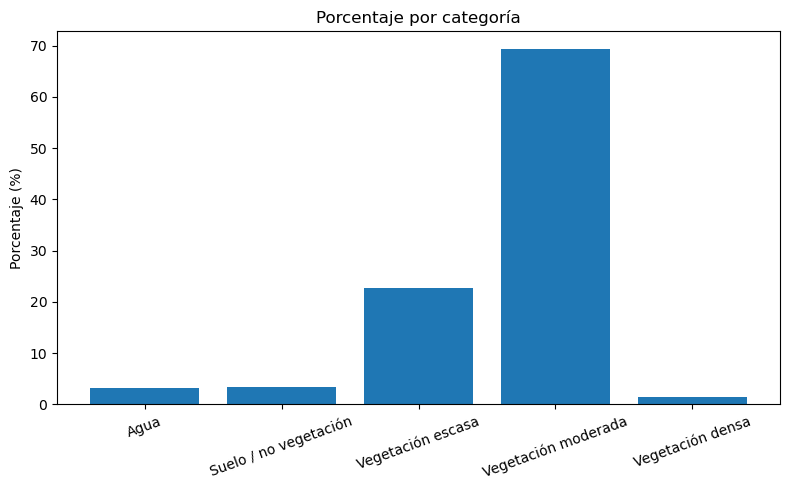

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


ruta = r"D:\LANDSANT\RASTERS\historicos\DATOS\20240909.xlsx"

# 1) Leer Excel: decimal=',' para comas; forzamos NDVI a entero (categoría)
df = pd.read_excel(ruta, decimal=',')
df["NDVI"] = pd.to_numeric(df["NDVI"], errors="coerce").astype("Int64")
df["AREA"] = pd.to_numeric(df["AREA"], errors="coerce")

# 2) Sumar AREA por categoría (1..5)
res = (
    df.dropna(subset=["NDVI","AREA"])
      .query("AREA > 0")
      .groupby("NDVI", dropna=True)["AREA"]
      .sum()
      .rename("AREA_total")
      .reset_index()
      .sort_values("NDVI")
)

# 3) (Opcional) nombres amigables y porcentaje
nombres = {1:"Agua", 2:"Suelo / no vegetación", 3:"Vegetación escasa",
           4:"Vegetación moderada", 5:"Vegetación densa"}
res["Clase"] = res["NDVI"].map(nombres)
total = res["AREA_total"].sum()
res["Porcentaje_%"] = (res["AREA_total"] / total * 100).round(2)

print("\nSuma de AREA por categoría:")
print(res[["NDVI","Clase","AREA_total","Porcentaje_%"]])

# 4) Gráfico de barras con porcentajes
plt.figure(figsize=(8,5))
plt.bar(res["Clase"], res["Porcentaje_%"])
plt.ylabel("Porcentaje (%)")
plt.title("Porcentaje por categoría")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [8]:
# -*- coding: utf-8 -*-
import re
from pathlib import Path
import pandas as pd

# ===== EDITA: pon aquí tus archivos (cada uno es una fecha) =====
FILES = [
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20240909.xlsx", # 1
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20241212.xlsx", # 2
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20240410.xlsx", # 3
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20231212.xlsx", # 4
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20230603.xlsx", # 5
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20230211.xlsx", # 6
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20221217.xlsx", # 7
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20220819.xlsx", # 8
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20220131.xlsx", # 9
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20211003.xlsx", # 10
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20210309.xlsx", # 11
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20210104.xlsx", # 12
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20200829.xlsx", # 13
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20200306.xlsx", # 14
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20191030.xlsx", # 15
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20190710.xlsx", # 16
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20190131.xlsx", # 17
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20181230.xlsx", # 18
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20180824.xlsx", # 19
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20180317.xlsx", # 20
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20171211.xlsx", # 21
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20170906.xlsx", # 22
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20161122.xlsx", # 23
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20160530.xlsx", # 24
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20160123.xlsx", # 25
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20151222.xlsx", # 26
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20150325.xlsx", # 27
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20150104.xlsx", # 28
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20141219.xlsx", # 29
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20140930.xlsx", # 30
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20140101.xlsx", # 31
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20131216.xlsx", # 32
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20131029.xlsx", # 33
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20251212.xlsx", # PREDICION
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20261212.xlsx", # PREDICION
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20271212.xlsx", # PREDICION
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20281212.xlsx", # PREDICION
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20291212.xlsx", # PREDICION
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20301212.xlsx", # PREDICION
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20311212.xlsx", # PREDICION
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20321212.xlsx", # PREDICION
]

# Nombres amigables (opcional)
NOMBRES = {1:"Agua", 2:"Suelo / no vegetación", 3:"Vegetación escasa", 4:"Vegetación moderada", 5:"Vegetación densa"}
ORDEN = [1,2,3,4,5]

def fecha_de_archivo(p: str):
    m = re.search(r"(\d{8})", Path(p).name)
    return pd.to_datetime(m.group(1), format="%Y%m%d", errors="coerce") if m else pd.NaT

rows = []
for f in FILES:
    fecha = fecha_de_archivo(f)
    if pd.isna(fecha):
        print("↷ Saltando (no pude leer fecha del nombre):", f);  continue

    df = pd.read_excel(f, sheet_name=0)
    # Asegurar tipos
    df["NDVI"] = pd.to_numeric(df["NDVI"], errors="coerce").astype("Int64")
    df["AREA"] = pd.to_numeric(df["AREA"], errors="coerce")

    # Suma por categoría (ya en hectáreas)
    s = (df.dropna(subset=["NDVI","AREA"])
           .query("AREA > 0")
           .groupby("NDVI")["AREA"].sum()
           .reindex(ORDEN, fill_value=0.0))

    rows.append({"fecha": fecha, **{NOMBRES[k]: float(s.loc[k]) for k in ORDEN}})

# === TABLA 1: hectáreas por fecha y categoría ===
areas = (pd.DataFrame(rows)
           .sort_values("fecha")
           .set_index("fecha")
           [[NOMBRES[k] for k in ORDEN]]
           .round(4))
print("\n🟩 Hectáreas por categoría (ha):")
areas

# === TABLA 2: porcentaje por fecha y categoría ===
pct = (areas.div(areas.sum(axis=1), axis=0)*100).round(2)
print("\n🔷 Porcentaje por categoría (%):")



🟩 Hectáreas por categoría (ha):

🔷 Porcentaje por categoría (%):


In [9]:
areas

,Agua,Suelo / no vegetación,Vegetación escasa,Vegetación moderada,Vegetación densa
fecha,,,,,
2013-10-29,2.3413,14.4082,14.7684,5.7633,0.0000
2013-12-16,2.3413,34.9399,0.0000,0.0000,0.0000
2014-01-01,2.9717,2.6115,24.5840,7.1141,0.0000
2014-09-30,1.3508,29.7169,4.1424,2.0712,0.0000
2014-12-19,1.7110,9.9957,24.8542,0.7204,0.0000
2015-01-04,1.5309,1.1707,18.0103,16.2993,0.2702
2015-03-25,1.5309,35.5703,0.1801,0.0000,0.0000
2015-12-22,2.0712,1.4408,19.0909,14.6784,0.0000
2016-01-23,2.2513,12.3370,21.8825,0.8105,0.0000


In [10]:
pct

,Agua,Suelo / no vegetación,Vegetación escasa,Vegetación moderada,Vegetación densa
fecha,,,,,
2013-10-29,6.28,38.65,39.61,15.46,0.00
2013-12-16,6.28,93.72,0.00,0.00,0.00
2014-01-01,7.97,7.00,65.94,19.08,0.00
2014-09-30,3.62,79.71,11.11,5.56,0.00
2014-12-19,4.59,26.81,66.67,1.93,0.00
2015-01-04,4.11,3.14,48.31,43.72,0.72
2015-03-25,4.11,95.41,0.48,0.00,0.00
2015-12-22,5.56,3.86,51.21,39.37,0.00
2016-01-23,6.04,33.09,58.70,2.17,0.00


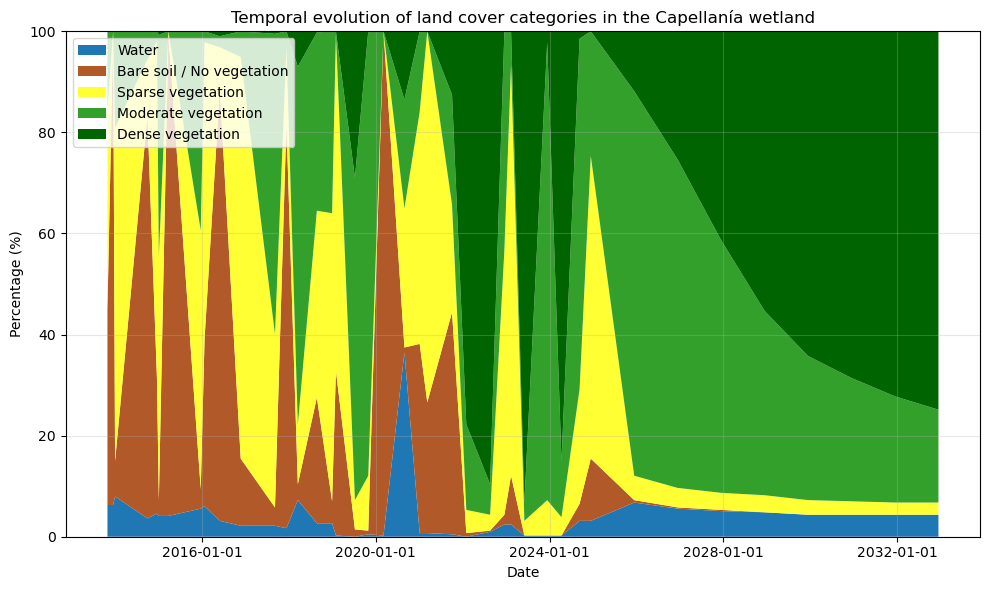

✅ Gráfico guardado en: C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\area_apilada2.png


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Normaliza índice de fecha y tipos numéricos ---
if "fecha" in pct.columns:
    pct["fecha"] = pd.to_datetime(pct["fecha"], errors="coerce")
    pct = pct.set_index("fecha")
else:
    pct.index = pd.to_datetime(pct.index, errors="coerce")
pct = pct.apply(pd.to_numeric, errors="coerce").sort_index()

# --- Mapa ES -> EN (solo si tus columnas aún están en español) ---
rename_map = {
    "Agua": "Water",
    "Suelo / no vegetación": "Bare soil / No vegetation",
    "Vegetación escasa": "Sparse vegetation",
    "Vegetación moderada": "Moderate vegetation",
    "Vegetación densa": "Dense vegetation",
}
pct = pct.rename(columns=rename_map)

# --- Paleta (sin espacios extra) ---
palette = {
    "Water": "#1f78b4",
    "Bare soil / No vegetation": "#b15928",
    "Sparse vegetation": "#ffff33",
    "Moderate vegetation": "#33a02c",
    "Dense vegetation": "#006400",
}

# Orden y colores según columnas presentes
order = ["Water", "Bare soil / No vegetation", "Sparse vegetation",
         "Moderate vegetation", "Dense vegetation"]
cols = [c for c in order if c in pct.columns]
colors = [palette[c] for c in cols]

# --- Gráfico área apilada ---
plt.figure(figsize=(10, 6))
x = pct.index
y = [pct[c].values for c in cols]
plt.stackplot(x, *y, labels=cols, colors=colors)

plt.title("Temporal evolution of land cover categories in the Capellanía wetland")
plt.xlabel("Date")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# --- Guardar en PNG 900 dpi ---
out_path = r"C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\area_apilada2.png"
plt.savefig(out_path, dpi=900, bbox_inches="tight", format="png")
plt.show()

print(f"✅ Gráfico guardado en: {out_path}")

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ 1) DIAGNÓSTICO ------------------
df = pct.copy()

# Asegura índice datetime SIN agrupar por año
if "fecha" in df.columns:
    df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
    df = df.set_index("fecha")
else:
    df.index = pd.to_datetime(df.index, errors="coerce")

# Ordena y quita filas sin fecha (NaT)
df = df.sort_index()
df = df[~df.index.isna()]

order = ["Agua", "Suelo / no vegetación", "Vegetación escasa",
         "Vegetación moderada", "Vegetación densa"]

# ¿Existen todas las columnas?
missing = [c for c in order if c not in df.columns]
print("-> shape antes de convertir:", df.shape)
print("-> columnas presentes:", [c for c in order if c in df.columns])
print("-> columnas faltantes:", missing[:])

# Convierte a numérico
for c in order:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Quita filas completamente vacías y rellena con 0 el resto
df = df[order].dropna(how="all").fillna(0)

print("-> shape después de limpiar:", df.shape)
print("-> primeras fechas:", df.index[:5].astype(str).tolist())
print("-> ¿valores numéricos? dtypes:\n", df.dtypes)

# Si después de limpiar queda una sola fila, avisamos y salimos
if len(df) <= 1:
    raise RuntimeError("El DataFrame para graficar tiene 1 o menos filas. Revisa que no se haya filtrado o agrupado antes.")

# ------------------ 2) GRÁFICO: BARRAS APILADAS POR FECHA ------------------
palette = {
    "Agua": "#1f78b4",
    "Suelo / no vegetación": "#b15928",
    "Vegetación escasa": "#ffff33",
    "Vegetación moderada": "#33a02c",
    "Vegetación densa": "#006400",
}

# Construimos las barras manualmente para poner TODAS las fechas
x = np.arange(len(df))         # posición por fecha
width = 0.85
bottom = np.zeros(len(df))

fig, ax = plt.subplots(figsize=(16, 6))

for c in order:
    vals = df[c].to_numpy() if c in df.columns else np.zeros(len(df))
    ax.bar(x, vals, width, bottom=bottom, color=palette[c], edgecolor="black", label=c)
    bottom += vals

ax.set_title("Porcentaje de cobertura por categoría (por fecha)", fontsize=14, weight="bold")
ax.set_ylabel("Porcentaje (%)")
ax.set_ylim(0, 100)
ax.set_yticks(np.arange(0, 101, 20))
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Etiquetas: TODAS las fechas (si son muchas, quedarán apretadas pero se verán)
labels = df.index.strftime("%Y-%m-%d")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90, ha="center", fontsize=8)

ax.legend(title="Categorías NDVI", loc="upper center",
          bbox_to_anchor=(0.5, -0.18), ncol=3, frameon=True)

plt.tight_layout()

# Guardar PNG 900 dpi
out_path = r"C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\ndvi_barras_por_fecha.png"
plt.savefig(out_path, dpi=900, bbox_inches="tight", format="png")
plt.show()

print(f"✅ Gráfico guardado en: {out_path}")

-> shape antes de convertir: (41, 5)
-> columnas presentes: []
-> columnas faltantes: ['Agua', 'Suelo / no vegetación', 'Vegetación escasa', 'Vegetación moderada', 'Vegetación densa']


KeyError: "None of [Index(['Agua', 'Suelo / no vegetación', 'Vegetación escasa',\n       'Vegetación moderada', 'Vegetación densa'],\n      dtype='object')] are in the [columns]"

In [ ]:
import os
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1) Explicador para RandomForest
explainer = shap.TreeExplainer(rf)

# 2) Calcula SHAP sobre el set de prueba
shap_values = explainer.shap_values(X_test)

# 3) Dibuja SOLO la gráfica de barras (importancia global)
plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=feature_cols,
                  plot_type="bar", show=False)
plt.tight_layout()

# 4) Guardar y/o mostrar
#   - Si en tu script existe out_dir, se guarda allí en /SHAP/
#   - Si no existe out_dir, se guarda en la carpeta actual
try:
    shap_dir = os.path.join(out_dir, "SHAP")
    os.makedirs(shap_dir, exist_ok=True)
    plt.savefig(os.path.join(shap_dir, "shap_bar.png"), dpi=600, bbox_inches="tight")
except Exception:
    plt.savefig("shap_bar.png", dpi=600, bbox_inches="tight")

plt.show()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Ruta de salida
out_path = r"C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\shap_bar_5.png"

plt.figure(figsize=(7, 4))
ypos = np.arange(len(features_sorted))

bars = plt.barh(ypos, vals_sorted, color="#1f77b4")
plt.yticks(ypos, features_sorted)
plt.gca().invert_yaxis()
plt.xlabel("mean(|SHAP value|)")
plt.title("Variable Importance (SHAP)")

# Extender margen del eje X para que entren etiquetas
plt.xlim(0, max(vals_sorted) * 1.2)

# Etiquetas al final de cada barra
for bar, val in zip(bars, vals_sorted):
    plt.text(
        bar.get_width() + max(vals_sorted) * 0.02,
        bar.get_y() + bar.get_height() / 2,
        f"+{val:.2f}",
        va="center", ha="left", fontsize=9, color="#1f77b4"
    )

plt.tight_layout()

# Guardar en la ruta indicada con 900 dpi
plt.savefig(out_path, dpi=900, bbox_inches="tight", format="png")

# Mostrar en pantalla
plt.show()

print(f"✅ Gráfico guardado en: {out_path}")

NameError: name 'features_sorted' is not defined

<Figure size 700x400 with 0 Axes>

In [28]:
# -*- coding: utf-8 -*-
import re
from pathlib import Path
import pandas as pd
import numpy as np

FILES = [
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20240909.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20241212.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20240410.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20231212.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20230603.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20230211.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20221217.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20220819.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20220131.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20211003.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20210309.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20210104.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20200829.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20200306.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20191030.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20190710.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20190131.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20181230.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20180824.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20180317.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20171211.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20170906.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20161122.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20160530.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20160123.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20151222.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20150325.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20150104.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20141219.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20140930.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20140101.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20131216.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20131029.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20251212.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20261212.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20271212.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20281212.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20291212.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20301212.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20311212.xlsx",
    r"D:\LANDSANT\RASTERS\historicos\DATOS\20321212.xlsx",
]

NOMBRES = {1:"Agua", 2:"Suelo / no vegetación", 3:"Vegetación escasa", 4:"Vegetación moderada", 5:"Vegetación densa"}
ORDEN   = [1,2,3,4,5]

def fecha_de_archivo(p: str):
    m = re.search(r"(\d{8})", Path(p).name)
    return pd.to_datetime(m.group(1), format="%Y%m%d", errors="coerce") if m else pd.NaT

def leer_areas_por_categoria(path_xlsx: str):
    """Devuelve Serie con índices 1..5 (NDVI) y valor=AREA (ha)."""
    # 1) leer la hoja que tenga NDVI y AREA
    xls = pd.ExcelFile(path_xlsx)
    hoja_ok = None
    for nombre_hoja in xls.sheet_names:
        tmp = pd.read_excel(path_xlsx, sheet_name=nombre_hoja)
        cols = {c.strip().upper() for c in tmp.columns.astype(str)}
        if "NDVI" in cols and "AREA" in cols:
            hoja_ok = nombre_hoja
            break
    if hoja_ok is None:
        raise KeyError("No encontré columnas NDVI y AREA en ninguna hoja")

    df = pd.read_excel(path_xlsx, sheet_name=hoja_ok)
    # 2) asegurar tipos
    df["NDVI"] = pd.to_numeric(df["NDVI"], errors="coerce")
    df["AREA"] = pd.to_numeric(df["AREA"], errors="coerce")
    df = df.dropna(subset=["NDVI","AREA"])
    # muchas veces NDVI llega como 1.0..5.0 -> redondeo y paso a int
    df["NDVI"] = df["NDVI"].round().astype(int)

    # 3) sumar por clase 1..5
    s = df.loc[df["AREA"]>0, ["NDVI","AREA"]].groupby("NDVI")["AREA"].sum()
    # rellenar faltantes
    s = s.reindex(ORDEN, fill_value=0.0)
    return s

rows = []
errores = []
for f in FILES:
    fecha = fecha_de_archivo(f)
    try:
        s = leer_areas_por_categoria(f)
        rows.append({"fecha": fecha, **{NOMBRES[k]: float(s.loc[k]) for k in ORDEN}})
    except Exception as e:
        errores.append((f, str(e)))

# Reporte rápido
print(f"✔️ archivos OK: {len(rows)}   ❗ errores: {len(errores)}")
if errores:
    print("Algunos archivos dieron error:")
    for f,msg in errores[:5]:
        print(" -", Path(f).name, "->", msg)

# === TABLA 1: hectáreas por fecha y categoría ===
areas = (pd.DataFrame(rows)
           .dropna(subset=["fecha"])
           .sort_values("fecha")
           .set_index("fecha")
           [[NOMBRES[k] for k in ORDEN]]
           .round(4))
print("areas.shape =", areas.shape)

# === TABLA 2: porcentaje por fecha y categoría ===
pct = (areas.div(areas.sum(axis=1).replace(0, np.nan), axis=0)*100).fillna(0).round(2)
print("pct.shape   =", pct.shape)

✔️ archivos OK: 41   ❗ errores: 0
areas.shape = (41, 5)
pct.shape   = (41, 5)


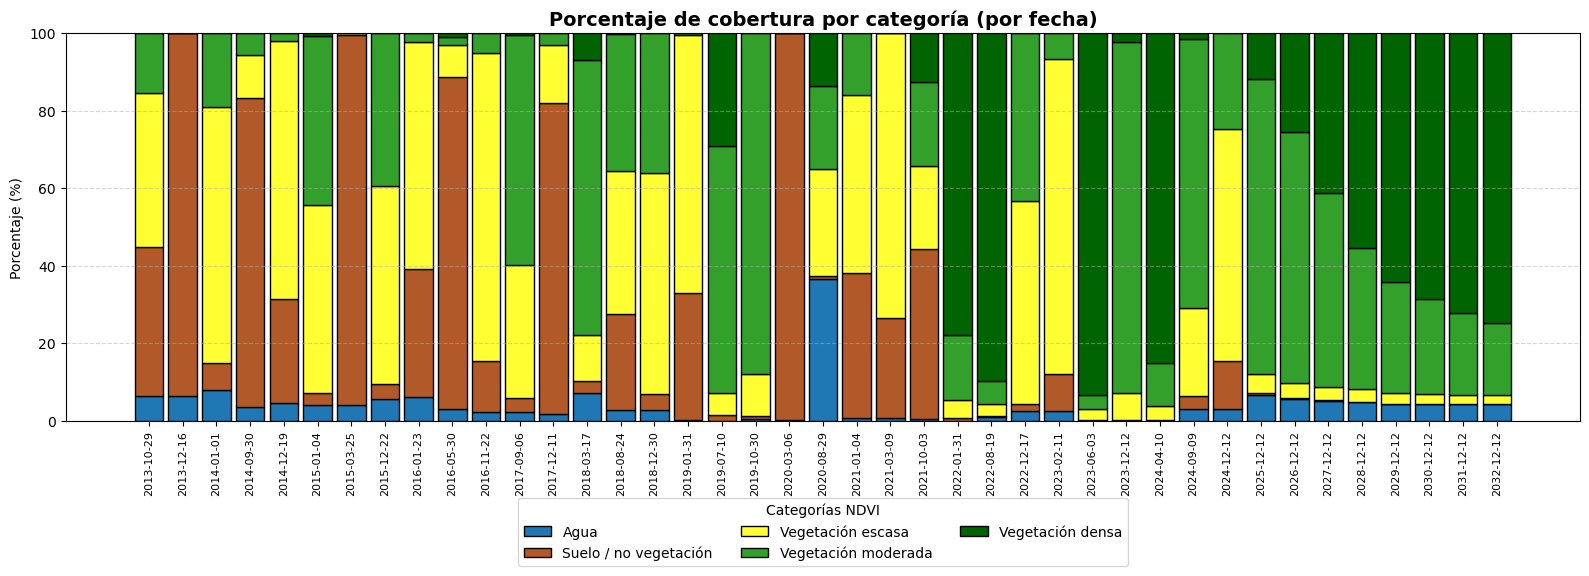

✅ Gráfico guardado en: C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\ndvi_barras_por_fecha.png


In [29]:
import matplotlib.pyplot as plt

order   = ["Agua","Suelo / no vegetación","Vegetación escasa","Vegetación moderada","Vegetación densa"]
palette = {"Agua":"#1f78b4","Suelo / no vegetación":"#b15928","Vegetación escasa":"#ffff33",
           "Vegetación moderada":"#33a02c","Vegetación densa":"#006400"}

# Asegura index datetime y orden
pct = pct.copy()
pct.index = pd.to_datetime(pct.index, errors="coerce")
pct = pct.sort_index()

cols = [c for c in order if c in pct.columns]
data = pct[cols].apply(pd.to_numeric, errors="coerce").fillna(0)

# ---- Barras apiladas (una barra por fecha) ----
import numpy as np
x = np.arange(len(data))
width = 0.85
bottom = np.zeros(len(data))

fig, ax = plt.subplots(figsize=(16, 6))
for c in cols:
    ax.bar(x, data[c].to_numpy(), width, bottom=bottom, color=palette[c], edgecolor="black", label=c)
    bottom += data[c].to_numpy()

ax.set_title("Porcentaje de cobertura por categoría (por fecha)", fontsize=14, weight="bold")
ax.set_ylabel("Porcentaje (%)")
ax.set_ylim(0, 100)
ax.set_yticks(np.arange(0,101,20))
ax.grid(axis="y", linestyle="--", alpha=0.5)

# etiquetas: todas las fechas (si son muchas, quedarán juntas)
labels = data.index.strftime("%Y-%m-%d")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90, ha="center", fontsize=8)

ax.legend(title="Categorías NDVI", loc="upper center",
          bbox_to_anchor=(0.5, -0.18), ncol=3, frameon=True)

plt.tight_layout()
out_path = r"C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\ndvi_barras_por_fecha.png"
plt.savefig(out_path, dpi=900, bbox_inches="tight", format="png")
plt.show()

print("✅ Gráfico guardado en:", out_path)

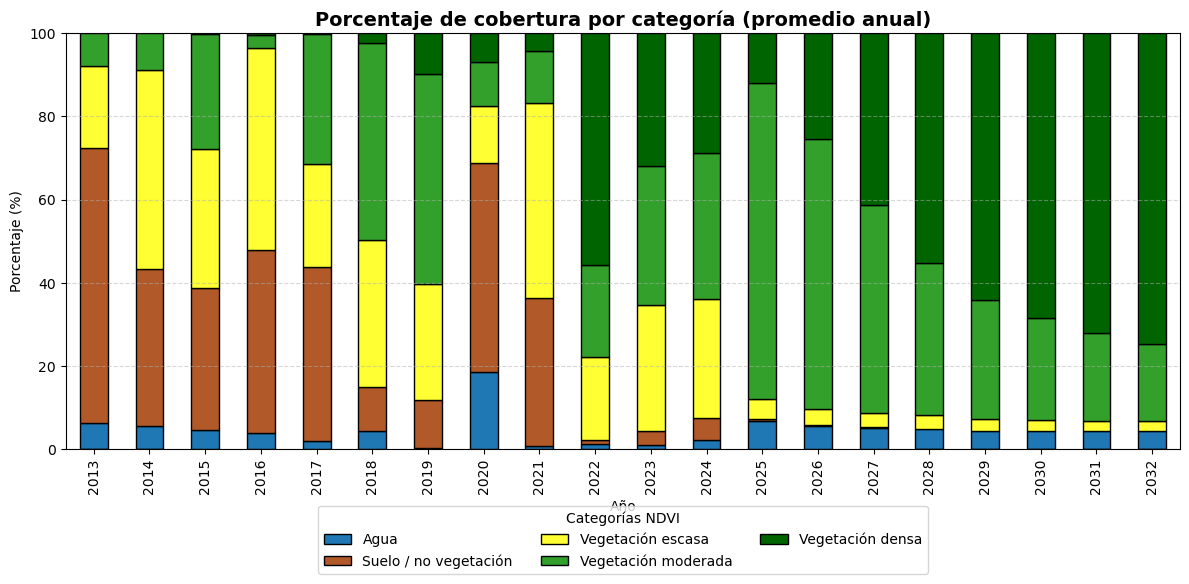

✅ Gráfico anual guardado en: C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\ndvi_barras_por_anio.png


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1) Asegurar fechas e index ----------
pct_year = pct.copy()
pct_year.index = pd.to_datetime(pct_year.index, errors="coerce")
pct_year = pct_year.sort_index()

# ---------- 2) Agregar por AÑO (promedio de % en el año) ----------
pct_year = pct_year.groupby(pct_year.index.year).mean()
pct_year.index.name = "Año"

# ---------- 3) Orden de categorías y paleta ----------
order = ["Agua", "Suelo / no vegetación", "Vegetación escasa",
         "Vegetación moderada", "Vegetación densa"]
palette = {
    "Agua": "#1f78b4",
    "Suelo / no vegetación": "#b15928",
    "Vegetación escasa": "#ffff33",
    "Vegetación moderada": "#33a02c",
    "Vegetación densa": "#006400",
}

cols = [c for c in order if c in pct_year.columns]
data = pct_year[cols].apply(pd.to_numeric, errors="coerce").fillna(0).clip(lower=0)

# (Opcional) forzar que cada año sume 100 exacto
# sums = data.sum(axis=1).replace(0, 1)
# data = data.div(sums, axis=0) * 100

# ---------- 4) Barras apiladas por AÑO ----------
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(kind="bar", stacked=True, color=[palette[c] for c in cols],
          edgecolor="black", ax=ax)

ax.set_title("Porcentaje de cobertura por categoría (promedio anual)", fontsize=14, weight="bold")
ax.set_xlabel("Año")
ax.set_ylabel("Porcentaje (%)")
ax.set_ylim(0, 100)
ax.set_yticks(np.arange(0, 101, 20))
ax.grid(axis="y", linestyle="--", alpha=0.5)

ax.legend(title="Categorías NDVI", loc="upper center",
          bbox_to_anchor=(0.5, -0.12), ncol=3, frameon=True)

plt.tight_layout()
out_path = r"C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\ndvi_barras_por_anio.png"
plt.savefig(out_path, dpi=900, bbox_inches="tight", format="png")
plt.show()

print(f"✅ Gráfico anual guardado en: {out_path}")

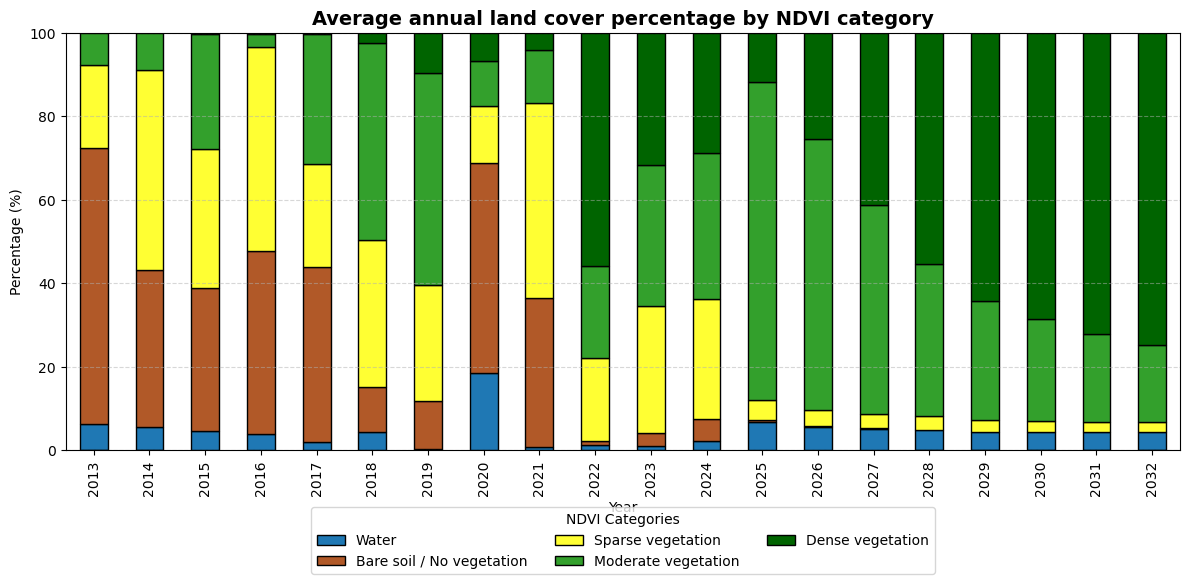

✅ Annual chart (English) saved at: C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\ndvi_barras_per_year_en.png


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1) Ensure datetime index ----------
pct_year = pct.copy()
pct_year.index = pd.to_datetime(pct_year.index, errors="coerce")
pct_year = pct_year.sort_index()

# ---------- 2) Aggregate by YEAR (average %) ----------
pct_year = pct_year.groupby(pct_year.index.year).mean()
pct_year.index.name = "Year"

# ---------- 3) Categories and palette ----------
order = ["Water", "Bare soil / No vegetation", "Sparse vegetation",
         "Moderate vegetation", "Dense vegetation"]

palette = {
    "Water": "#1f78b4",
    "Bare soil / No vegetation": "#b15928",
    "Sparse vegetation": "#ffff33",
    "Moderate vegetation": "#33a02c",
    "Dense vegetation": "#006400",
}

# If columns are still in Spanish, rename them
pct_year = pct_year.rename(columns={
    "Agua": "Water",
    "Suelo / no vegetación": "Bare soil / No vegetation",
    "Vegetación escasa": "Sparse vegetation",
    "Vegetación moderada": "Moderate vegetation",
    "Vegetación densa": "Dense vegetation"
})

cols = [c for c in order if c in pct_year.columns]
data = pct_year[cols].apply(pd.to_numeric, errors="coerce").fillna(0).clip(lower=0)

# ---------- 4) Stacked bar per YEAR ----------
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(kind="bar", stacked=True, color=[palette[c] for c in cols],
          edgecolor="black", ax=ax)

ax.set_title("Average annual land cover percentage by NDVI category", fontsize=14, weight="bold")
ax.set_xlabel("Year")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)
ax.set_yticks(np.arange(0, 101, 20))
ax.grid(axis="y", linestyle="--", alpha=0.5)

ax.legend(title="NDVI Categories", loc="upper center",
          bbox_to_anchor=(0.5, -0.12), ncol=3, frameon=True)

plt.tight_layout()
out_path = r"C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\ndvi_barras_per_year_en.png"
plt.savefig(out_path, dpi=900, bbox_inches="tight", format="png")
plt.show()

print(f"✅ Annual chart (English) saved at: {out_path}")

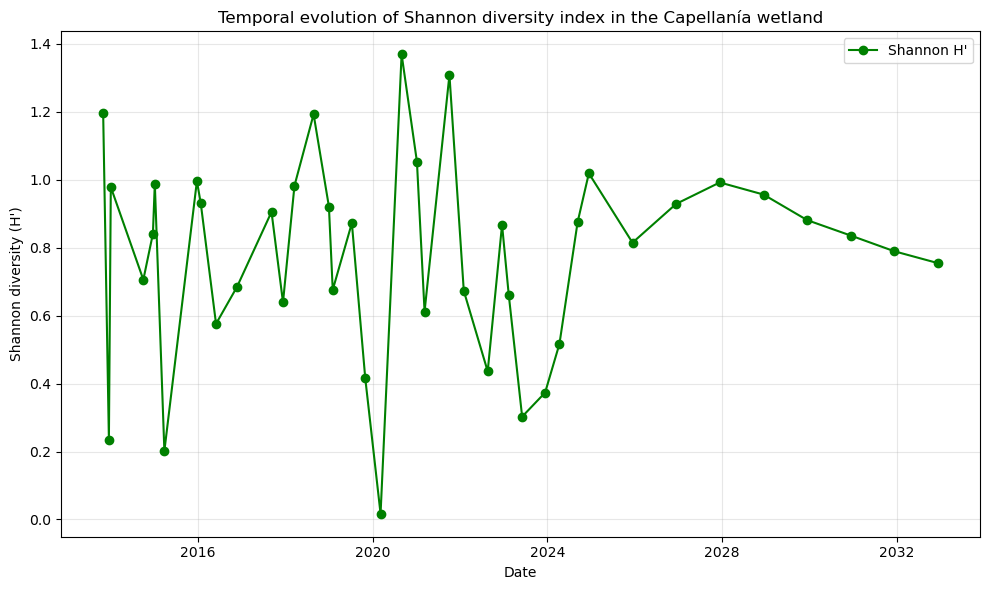

✅ Graph saved at: C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\shannon_evolution.png


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pct = tu DataFrame con porcentajes por categoría y fechas como índice
# Aseguramos que el índice sea datetime
pct.index = pd.to_datetime(pct.index, errors="coerce")

# Función para calcular Shannon
def shannon_index(row):
    proportions = row / 100.0  # trabajar con porcentajes
    proportions = proportions[proportions > 0]  # evitar log(0)
    return -np.sum(proportions * np.log(proportions))

# Calcular H' por fecha
H_series = pct.apply(shannon_index, axis=1)

# Gráfico en inglés
plt.figure(figsize=(10, 6))
plt.plot(H_series.index, H_series.values, marker="o", linestyle="-", color="green", label="Shannon H'")
plt.title("Temporal evolution of Shannon diversity index in the Capellanía wetland")
plt.xlabel("Date")
plt.ylabel("Shannon diversity (H')")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# Guardar en PNG con 900 dpi
out_path = r"C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\shannon_evolution.png"
plt.savefig(out_path, dpi=900, bbox_inches="tight", format="png")

plt.show()
print(f"✅ Graph saved at: {out_path}")

In [35]:
import pandas as pd
import numpy as np

# Asegurar índice datetime
pct.index = pd.to_datetime(pct.index, errors="coerce")

# Definir año inicial y final
start_year = 2013
end_year = 2032
n_years = end_year - start_year

# Extraer valores iniciales y finales
initial = pct[pct.index.year == start_year].iloc[0]
final = pct[pct.index.year == end_year].iloc[0]

# Calcular CAGR por categoría
cagr = ((final / initial) ** (1 / n_years)) - 1

# Convertir a porcentaje
cagr_percent = (cagr * 100).round(2)

print("📊 CAGR por categoría entre 2013 y 2032:")
cagr_percent

📊 CAGR por categoría entre 2013 y 2032:


Agua                      -1.91
Suelo / no vegetación   -100.00
Vegetación escasa        -13.68
Vegetación moderada        0.91
Vegetación densa            inf
dtype: float64

In [36]:
import pandas as pd
import numpy as np

# Asegurar índices de tiempo
areas.index = pd.to_datetime(areas.index, errors="coerce")
pct.index = pd.to_datetime(pct.index, errors="coerce")

# Definir año inicial y final
start_year = 2013
end_year = 2032
n_years = end_year - start_year

# Valores iniciales y finales en hectáreas
areas_initial = areas[areas.index.year == start_year].iloc[0]
areas_final = areas[areas.index.year == end_year].iloc[0]

# Valores iniciales y finales en porcentajes
pct_initial = pct[pct.index.year == start_year].iloc[0]
pct_final = pct[pct.index.year == end_year].iloc[0]

# Calcular CAGR para hectáreas
cagr_areas = ((areas_final / areas_initial) ** (1 / n_years)) - 1

# Calcular CAGR para porcentajes
cagr_pct = ((pct_final / pct_initial) ** (1 / n_years)) - 1

# Unir resultados en una tabla
tabla_cagr = pd.DataFrame({
    "CAGR Hectáreas (%)": (cagr_areas * 100).round(2),
    "CAGR Porcentajes (%)": (cagr_pct * 100).round(2)
})

print("📊 Tasa Compuesta de Crecimiento Anual (2013–2032):")
print(tabla_cagr)

# Exportar a Excel si quieres
out_path = r"C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\CAGR_capellania.xlsx"
tabla_cagr.to_excel(out_path)
print(f"✅ Tabla exportada a: {out_path}")

📊 Tasa Compuesta de Crecimiento Anual (2013–2032):
                       CAGR Hectáreas (%)  CAGR Porcentajes (%)
Agua                                -1.92                 -1.91
Suelo / no vegetación             -100.00               -100.00
Vegetación escasa                  -13.69                -13.68
Vegetación moderada                  0.91                  0.91
Vegetación densa                      inf                   inf
✅ Tabla exportada a: C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\CAGR_capellania.xlsx


100%|===================| 2770/2772 [18:22<00:00]        

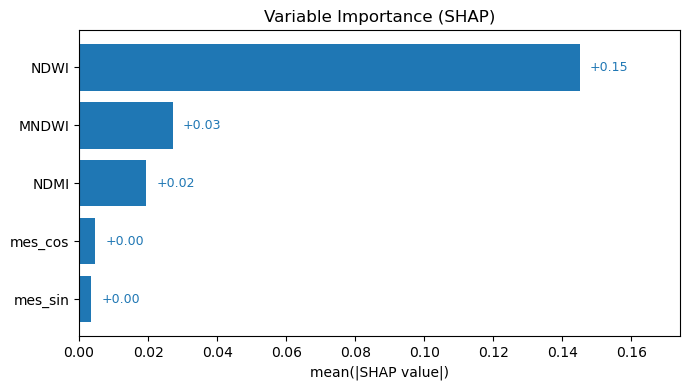

✅ Gráfico SHAP guardado en: C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\shap_bar_5.png


In [6]:
import os, math
import numpy as np
import matplotlib.pyplot as plt
import shap

# --- Requiere que ya existan: rf (RandomForestRegressor), X_train (DataFrame) y X_test (DataFrame) ---

# Alinea columnas por si el modelo guarda el orden
X_test_plot = X_test
if hasattr(rf, "feature_names_in_"):
    X_test_plot = X_test[rf.feature_names_in_]

# Muestra de fondo para SHAP (interventional) y estabilidad
n_bg = min(2000, len(X_train))
background = X_train.sample(n=n_bg, random_state=42)

# Evita el error de hojas no cubiertas usando "interventional"
explainer = shap.TreeExplainer(rf, data=background, feature_perturbation="interventional")

# check_additivity=False evita advertencias/mismatch por aproximaciones
shap_values = explainer.shap_values(X_test_plot, check_additivity=False)  # (n_muestras, n_features)

# Importancia media absoluta por variable
vals = np.mean(np.abs(shap_values), axis=0)
vals = np.nan_to_num(vals, nan=0.0, posinf=0.0, neginf=0.0)
features = list(X_test_plot.columns)

# Orden descendente
order = np.argsort(vals)[::-1]
features_sorted = [features[i] for i in order]
vals_sorted = vals[order]

# --- Gráfica horizontal (azul) y guardado a 900 dpi ---
out_path = r"C:\Users\Oscar Cáceres\Desktop\COMPOSICIONES\shap_bar_5.png"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

plt.figure(figsize=(7, 4))
ypos = np.arange(len(features_sorted))
bars = plt.barh(ypos, vals_sorted, color="#1f77b4")
plt.yticks(ypos, features_sorted)
plt.gca().invert_yaxis()
plt.xlabel("mean(|SHAP value|)")
plt.title("Variable Importance (SHAP)")

vmax = float(np.max(vals_sorted)) if len(vals_sorted) else 0.0
if not np.isfinite(vmax) or vmax <= 0:
    vmax = 1.0
plt.xlim(0, vmax * 1.2)

offset = vmax * 0.02
for bar, val in zip(bars, vals_sorted):
    plt.text(bar.get_width() + offset,
             bar.get_y() + bar.get_height()/2,
             f"+{val:.2f}",
             va="center", ha="left", fontsize=9, color="#1f77b4")

plt.tight_layout()
plt.savefig(out_path, dpi=900, bbox_inches="tight", format="png")
plt.show()

print(f"✅ Gráfico SHAP guardado en: {out_path}")